In [2]:
library("h2o")

In [5]:
prosPath = system.file("extdata", "prostate.csv", package = "h2o")

prostate_df = read.csv(prosPath)

In [6]:
prostate_df <- prostate_df[ , -1]

summary(prostate_df)

    CAPSULE            AGE             RACE           DPROS      
 Min.   :0.0000   Min.   :43.00   Min.   :0.000   Min.   :1.000  
 1st Qu.:0.0000   1st Qu.:62.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :0.0000   Median :67.00   Median :1.000   Median :2.000  
 Mean   :0.4026   Mean   :66.04   Mean   :1.087   Mean   :2.271  
 3rd Qu.:1.0000   3rd Qu.:71.00   3rd Qu.:1.000   3rd Qu.:3.000  
 Max.   :1.0000   Max.   :79.00   Max.   :2.000   Max.   :4.000  
     DCAPS            PSA              VOL           GLEASON     
 Min.   :1.000   Min.   :  0.30   Min.   : 0.00   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:  5.00   1st Qu.: 0.00   1st Qu.:6.000  
 Median :1.000   Median :  8.75   Median :14.25   Median :6.000  
 Mean   :1.108   Mean   : 15.41   Mean   :15.81   Mean   :6.384  
 3rd Qu.:1.000   3rd Qu.: 17.12   3rd Qu.:26.45   3rd Qu.:7.000  
 Max.   :2.000   Max.   :139.70   Max.   :97.60   Max.   :9.000  

In [9]:

# Benchmark Random Forest model

set.seed(1234)

random_splits <- runif(nrow(prostate_df))

train_df <- prostate_df[random_splits < .5, ]

dim(train_df)

[1] 193   8

In [10]:
validate_df <- prostate_df[random_splits >= .5, ]

dim(validate_df)

[1] 187   8

In [13]:
library('randomForest')

outcome_name <- 'CAPSULE'

feature_names <- setdiff(names(prostate_df), outcome_name)

set.seed(1234)

rf_model <- randomForest(x = train_df[ , feature_names],
                        y = as.factor(train_df[ , outcome_name]),
                        importance = TRUE, ntree = 20, mtry = 3)

validate_predictions <- predict(rf_model, newdata = validate_df[ ,feature_names], type = 'prob')


In [14]:
head(validate_predictions)

,0,1
2,0.45,0.55
3,0.45,0.55
4,0.55,0.45
5,0.80,0.20
6,0.35,0.65
9,0.40,0.60


Setting levels: control = 0, case = 1

Setting direction: controls < cases



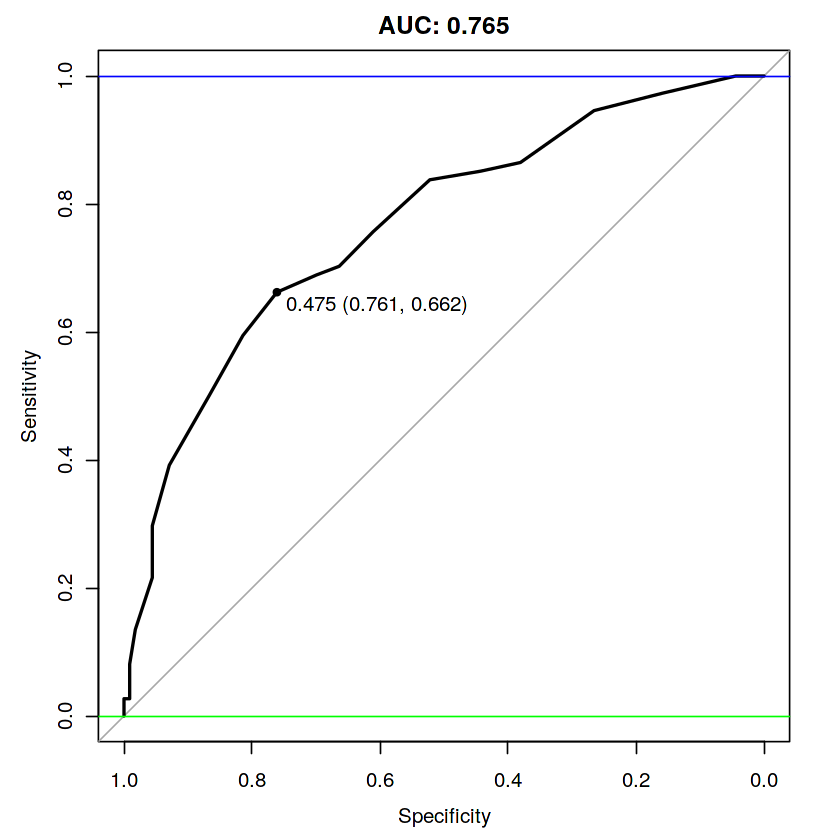

In [16]:
library(pROC)

auc_rf = roc(response = as.numeric(as.factor(validate_df[ , outcome_name])) - 1, 
            predictor = validate_predictions[ ,2])

plot(auc_rf, print.thres = "best", main = paste('AUC:', round(auc_rf$auc[[1]], 3)))

abline( h = 1, col = 'blue')

abline( h = 0, col = 'green')

In [18]:
# Autoencoder

library(h2o)

localH2O = h2o.init()

prostate.hex <- as.h2o(train_df, destination_frame = "train.hex")

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 minutes 3 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    3 months and 29 days !!! 
    H2O cluster name:           H2O_started_from_R_root_rvb811 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (3 months and 29 days)!
Please download and install the latest version from http://h2o.ai/download/”



  |======================================================================| 100%


In [19]:
prostate.dl = h2o.deeplearning(x = feature_names, training_frame = prostate.hex,
                              autoencoder = TRUE,
                              reproducible = T,
                              seed = 1234,
                              hidden = c(6,5,6), epochs = 50)

  |======================================================================| 100%


In [22]:
# interesting per feature score

prostate.anon = h2o.anomaly(prostate.dl, prostate.hex, per_feature = TRUE)

head(prostate.anon)

,reconstr_AGE.SE,reconstr_RACE.SE,reconstr_DPROS.SE,reconstr_DCAPS.SE,reconstr_PSA.SE,reconstr_VOL.SE,reconstr_GLEASON.SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001109467,0.001134259,0.01146638,0.01183924,0.012256013,3.565429e-02,0.002625309
2,0.005237080,0.136849144,0.31313592,0.79422266,0.001792563,4.014756e-02,0.002766275
3,0.090992737,0.110208095,0.31313592,0.79422266,0.055289564,9.534022e-06,0.003584817
4,0.046955137,0.012308289,0.31313592,0.79422266,0.013571392,3.565429e-02,0.069468122
5,0.104868587,0.001134259,0.19396494,0.01183924,0.004482023,3.565429e-02,0.026357158
6,0.104868587,0.217455502,0.19396494,0.01183924,0.010571113,3.565429e-02,0.026357158


In [23]:
prostate.anon = h2o.anomaly(prostate.dl, prostate.hex, per_feature = FALSE)

head(prostate.anon)

err <- as.data.frame(prostate.anon)

,Reconstruction.MSE
,<dbl>
1,0.01086928
2,0.18487874
3,0.19534905
4,0.18361655
5,0.05404293
6,0.08581583


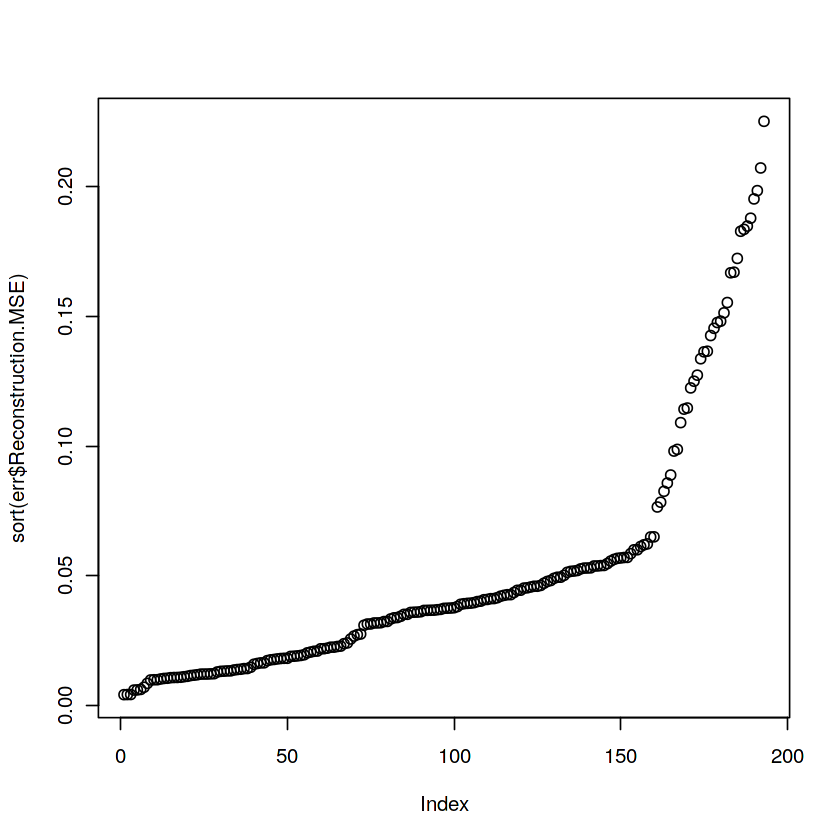

In [24]:
plot(sort(err$Reconstruction.MSE))

In [26]:
# Using dataset with err$Reconstruction less than 0.1 from above graph

train_df_auto <- train_df[err$Reconstruction.MSE < 0.07, ]

In [27]:
set.seed(1234)

rf_model <- randomForest(x = train_df_auto[ , feature_names],
                        y = as.factor(train_df_auto[ , outcome_name]),
                        importance = TRUE, ntree = 20, mtry = 3)

In [32]:
validate_predictions_known <- predict(rf_model, newdata = validate_df[,feature_names], type = 'prob')

In [33]:
auc_rf = roc(response = as.numeric(as.factor(validate_df[,outcome_name])) - 1,
            predictor = validate_predictions_known[,2])

Setting levels: control = 0, case = 1

Setting direction: controls < cases



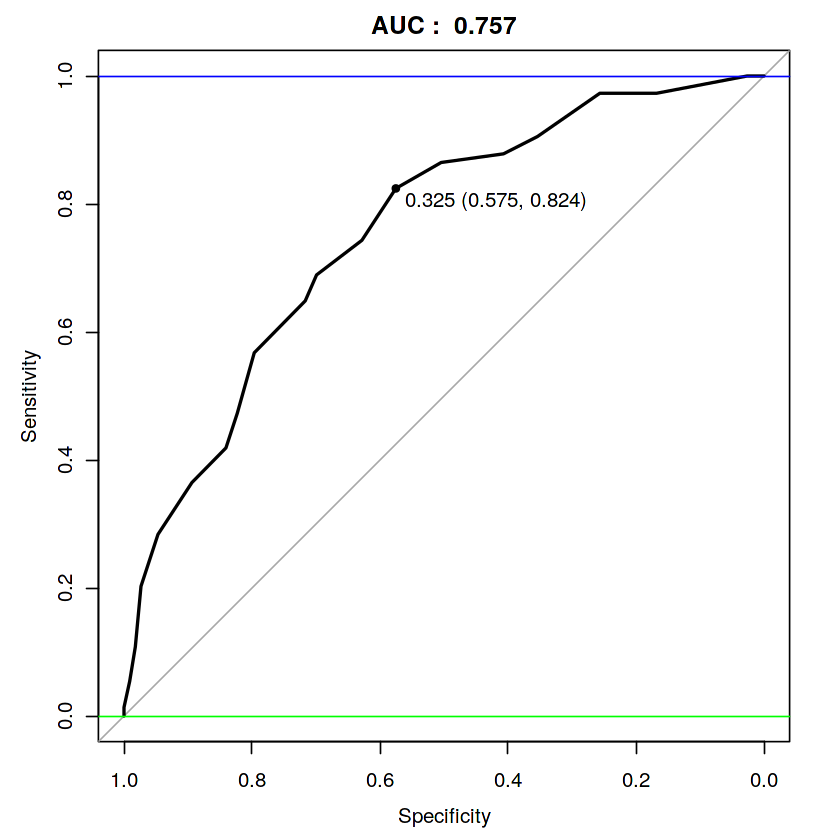

In [34]:
plot(auc_rf, print.thres = 'best', main = paste('AUC : ', round(auc_rf$auc[[1]], 3)))

abline(h = 1, col = 'blue')

abline(h = 0, col = 'green')

In [35]:
nrow(train_df_auto)

[1] 167

Setting levels: control = 0, case = 1

Setting direction: controls < cases



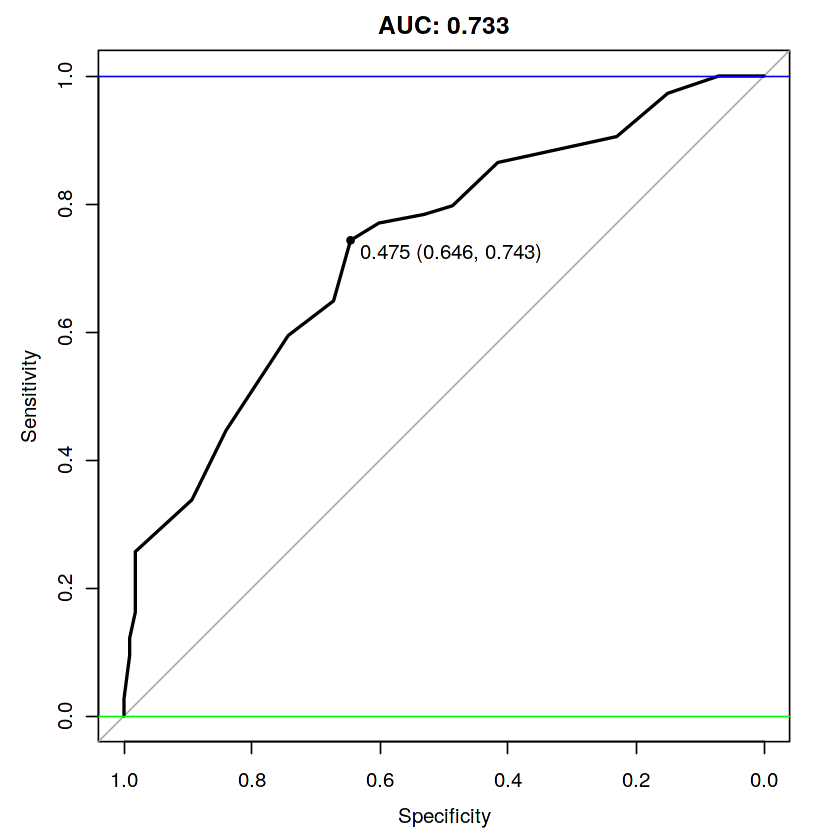

In [37]:
train_df_auto <- train_df[err$Reconstruction.MSE >= 0.07,]


set.seed(1234)
rf_model <- randomForest(x=train_df_auto[,feature_names],
                         y=as.factor(train_df_auto[,outcome_name]),
                         importance=TRUE, ntree=20, mtry = 3)

validate_predictions_unknown <- predict(rf_model, newdata=validate_df[,feature_names], type="prob")
auc_rf = roc(response=as.numeric(as.factor(validate_df[,outcome_name]))-1,
             predictor=validate_predictions_unknown[,2])

plot(auc_rf, print.thres = "best", main=paste('AUC:',round(auc_rf$auc[[1]],3)))
abline(h=1,col='blue')
abline(h=0,col='green')



Setting levels: control = 0, case = 1

Setting direction: controls < cases



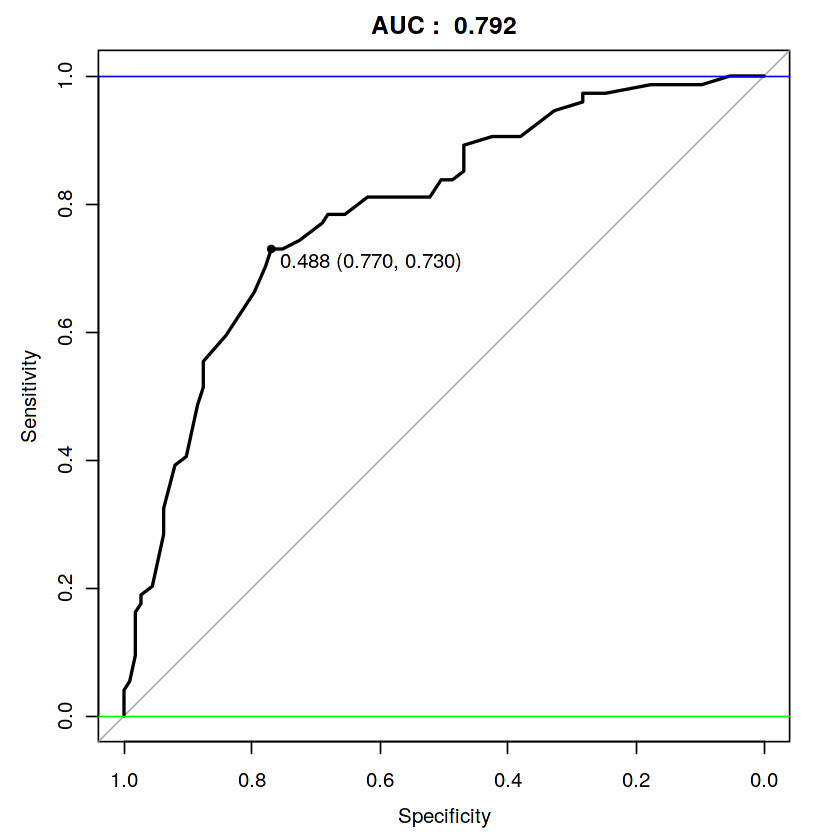

In [40]:
# measure final AUC score using both measures

valid_all <- (validate_predictions_known[,2] + validate_predictions_unknown[,2]) / 2

auc_rf = roc(response = as.numeric(as.factor(validate_df[, outcome_name])) - 1,
            predictor = valid_all)

plot(auc_rf, print.thres = "best", main = paste('AUC : ', round(auc_rf$auc[[1]], 3)))

abline(h = 1, col = 'blue')

abline(h = 0, col = 'green')